# Gold Recovery Analysis:


In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict

In [2]:
train_df = pd.read_csv('gold_recovery_train.csv')
test_df = pd.read_csv('gold_recovery_test.csv')
full_df = pd.read_csv('gold_recovery_full.csv')

In [3]:
#display(train_df.head())
#display(test_df.head())
#display(full_df.head())

## Confirm Recovery Calculations:

In [4]:

F = train_df['rougher.input.feed_au']
C = train_df['rougher.output.concentrate_au'] 
T = train_df['rougher.output.tail_au']

train_df['calc_recovery'] = 100 * ((C * (F - T)) / (F * (C - T)))

# Calculate MAE only on rows where both values exist
valid_mask = train_df['rougher.output.recovery'].notna() & train_df['calc_recovery'].notna()
mae_valid = mean_absolute_error(train_df.loc[valid_mask, 'rougher.output.recovery'], train_df.loc[valid_mask, 'calc_recovery']
)

print(f'Mean Absolute Error on raw data: {mae_valid}')


Mean Absolute Error on raw data: 9.210911277458828e-15


In [5]:
train_df = train_df.drop(columns=['calc_recovery'])

- For a quick sanity check we checked to make sure that the recovery data was calculated correctly. 
- This step helps us to ensure that the data is accurate and that previous calculations haven't been made in error. 
- We can move forward in our analysis with confidence for further calculations and testing. 

## Analysis of features between Train and Test set:

In [6]:

# Find features that exist in train but not in test
train_features = train_df.columns
test_features = test_df.columns

missing_in_test = train_features.difference(test_features)
print("Features in train but not in test:", missing_in_test.tolist())




Features in train but not in test: ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_au', 'rougher.ou

- Test set features exclude outputs because that is what we are trying to predict with our model based on the feature inputs.
- We will make sure that when it comes time for modeling, our feature sets between train/test sets are consistent.
- This insight will allow our model to make the best predictions possible since it will be using the same feature sets. 

## Data Preprocessing:

In [7]:
# Check for missing values across all datasets
print("Missing values in training set:")
print(train_df.isnull().sum().sort_values(ascending=False))

print("\nMissing values in test set:")
print(test_df.isnull().sum().sort_values(ascending=False))

Missing values in training set:
rougher.output.recovery                               2573
rougher.output.tail_ag                                2250
rougher.output.tail_sol                               2249
rougher.output.tail_au                                2249
secondary_cleaner.output.tail_sol                     1986
                                                      ... 
primary_cleaner.state.floatbank8_d_level                27
rougher.calculation.floatbank10_sulfate_to_au_feed      27
rougher.calculation.floatbank11_sulfate_to_au_feed      27
primary_cleaner.input.feed_size                          0
date                                                     0
Length: 87, dtype: int64

Missing values in test set:
rougher.input.floatbank11_xanthate            353
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
rougher.input.floatbank10_sulfate             257
primary_cleaner.input.xanthate                166
rougher.input.f

In [8]:
train_df.info()
test_df.info()
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [9]:
# Fill missing values in train and test sets using full dataset
full_df = full_df.fillna(method='ffill')
train_df = train_df.fillna(full_df.iloc[:len(train_df)])
test_df = test_df.fillna(full_df.iloc[len(train_df):])

# Forward fill any left over missing values for all columns
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')

# Check if it worked
print("Missing values after forward fill:")
print("Training set:", train_df.isnull().sum().sum())
print("Test set:", test_df.isnull().sum().sum())


Missing values after forward fill:
Training set: 0
Test set: 0


/var/folders/5j/4qz3kj0554x_34qmqj0s41br0000gn/T/ipykernel_12605/2909588392.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df = full_df.fillna(method='ffill')
/var/folders/5j/4qz3kj0554x_34qmqj0s41br0000gn/T/ipykernel_12605/2909588392.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df = train_df.fillna(method='ffill')
/var/folders/5j/4qz3kj0554x_34qmqj0s41br0000gn/T/ipykernel_12605/2909588392.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df = test_df.fillna(method='ffill')


- Looking at our data we can see there are various amounts of missing data across columns and datasets.
- To address missing data we will first use our full dataset to fill in any missing data in our train and test sets.
- This method allows us to keep the data as realistic as possible without the use of mean/median.
- Since our data is in sequential order, and due to the nature of processing gold, we can assume that any remaining missing data can be filled using forward fill.
- Between the use of our full data set and forward fill, further analysis of the data can be explored with high confidence in the data integrity. 

## Analyze the Data:

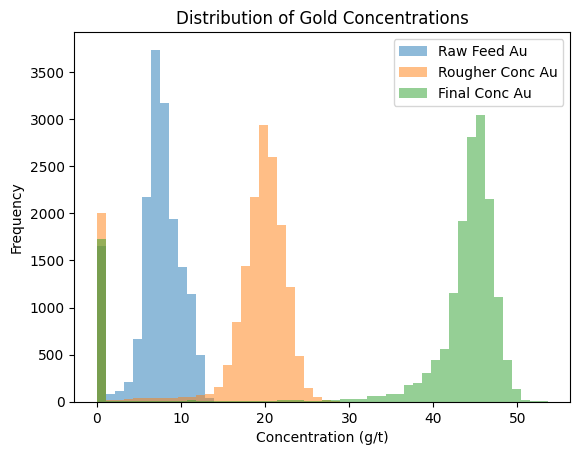

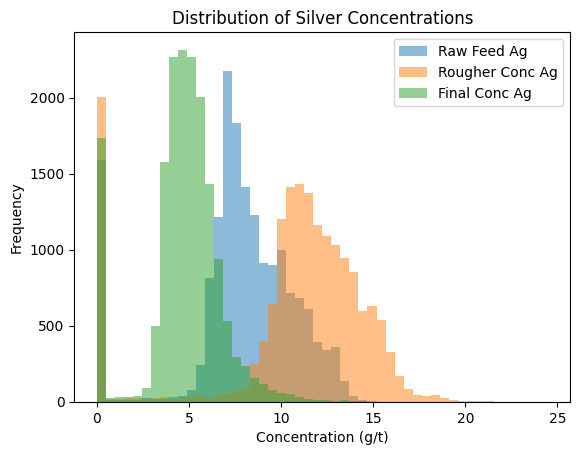

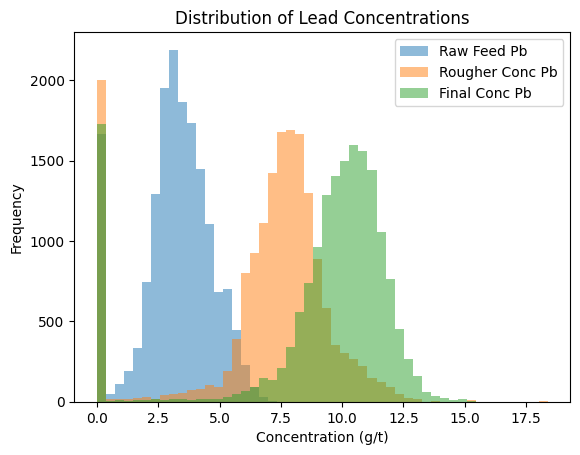

In [10]:
raw_feed_au = train_df['rougher.input.feed_au']
rougher_conc_au = train_df['rougher.output.concentrate_au'] 
final_conc_au = train_df['final.output.concentrate_au']

raw_feed_ag = train_df['rougher.input.feed_ag']
rougher_conc_ag = train_df['rougher.output.concentrate_ag']
final_conc_ag = train_df['final.output.concentrate_ag']

raw_feed_pb = train_df['rougher.input.feed_pb']
rougher_conc_pb = train_df['rougher.output.concentrate_pb']
final_conc_pb = train_df['final.output.concentrate_pb']


au_df = pd.concat([raw_feed_au, rougher_conc_au, final_conc_au], axis=1)
au_df.columns = ['Raw Feed Au', 'Rougher Conc Au', 'Final Conc Au']

ag_df = pd.concat([raw_feed_ag, rougher_conc_ag, final_conc_ag], axis=1)
ag_df.columns = ['Raw Feed Ag', 'Rougher Conc Ag', 'Final Conc Ag']

pb_df = pd.concat([raw_feed_pb, rougher_conc_pb, final_conc_pb], axis=1)
pb_df.columns = ['Raw Feed Pb', 'Rougher Conc Pb', 'Final Conc Pb']




au_df.plot.hist(bins=50, alpha=0.5)
plt.legend()
plt.title('Distribution of Gold Concentrations')
plt.xlabel('Concentration (g/t)')
plt.ylabel('Frequency')
plt.show()

ag_df.plot.hist(bins=50, alpha=0.5)
plt.legend()
plt.title('Distribution of Silver Concentrations')
plt.xlabel('Concentration (g/t)')
plt.ylabel('Frequency')
plt.show()

pb_df.plot.hist(bins=50, alpha=0.5)
plt.legend()
plt.title('Distribution of Lead Concentrations')
plt.xlabel('Concentration (g/t)')
plt.ylabel('Frequency')
plt.show()



- Our visual analysis of the distribution of concentrations between Gold, Silver and Lead gives us interesting insight. 
- We know that:
    - The rougher stage (flotation) concentrates ALL valuable metals together
    - The final stage (purification) is designed to selectively extract gold
- The goal is maximum gold purity in the final concentrate
- Notice how Lead and Gold both have their highest concentration in the final stage. 
    - This strongly suggests both elements have similar flotation properties.
- Silver on the other hand reaches it's lowest concentration by the final stage.
- Another noteworthly observation is the peak for each metal around 0 on the histogram:
    - These zero or low concentrations are likely due to the following:
        - No metals found in the material
        - Operational maintenence or shutdown
        - Error
    - While these low concentrations are noteworthy we aren't concerned about their effect on our analysis because of the overall quanitity of data we have. 

## Feed Particle Distribution:

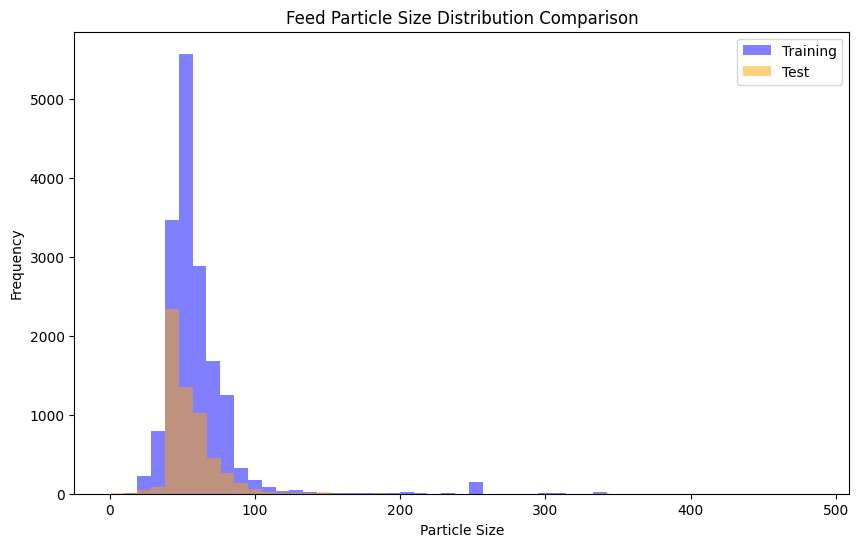

In [11]:
# Overlaid histograms for direct comparison
plt.figure(figsize=(10, 6))
plt.hist(train_df['rougher.input.feed_size'], bins=50, alpha=0.5, label='Training', color='blue')
plt.hist(test_df['rougher.input.feed_size'], bins=50, alpha=0.5, label='Test', color='orange')
plt.xlabel('Particle Size')
plt.ylabel('Frequency')
plt.title('Feed Particle Size Distribution Comparison')
plt.legend()
plt.show()

In [12]:
print("Training set statistics:")
print(train_df['rougher.input.feed_size'].describe())
print("\nTest set statistics:")
print(test_df['rougher.input.feed_size'].describe())

Training set statistics:
count    16860.000000
mean        60.211229
std         30.058878
min          9.659576
25%         47.549194
50%         54.062174
75%         65.380984
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Test set statistics:
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


- Both datasets show a right-skewed distribution with most particles concentrated in smaller sizes
- The peak occurs around particle size 40-60 for both training and test sets
- Very few particles exist beyond size 100

- - Training vs Test Comparison:

    - Similar patterns
        - Both datasets follow the same general distribution shape
    - Scale difference
        - training set has higher frequencies (more data points)
    - Peak alignment
        - both datasets peak at similar particle sizes

## Total Concentrations by Stage:

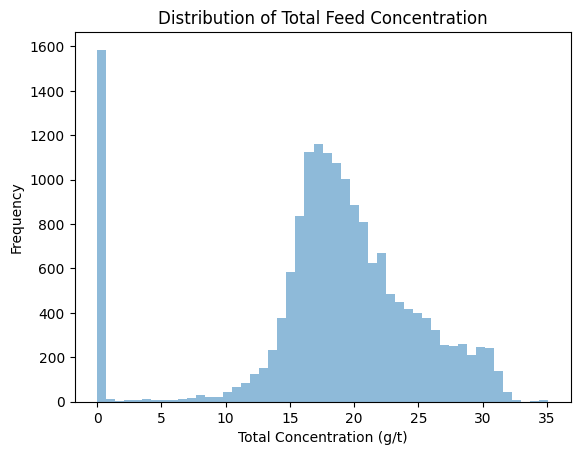

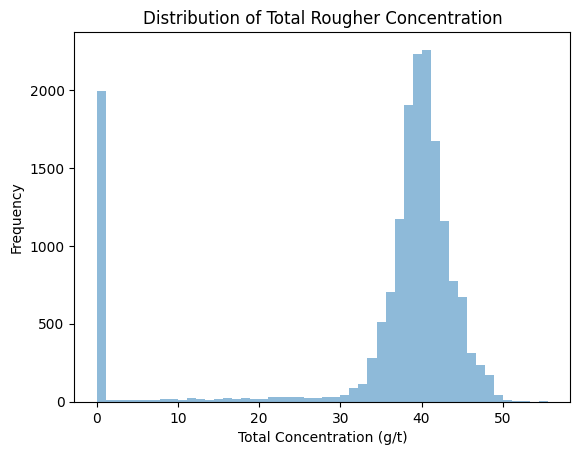

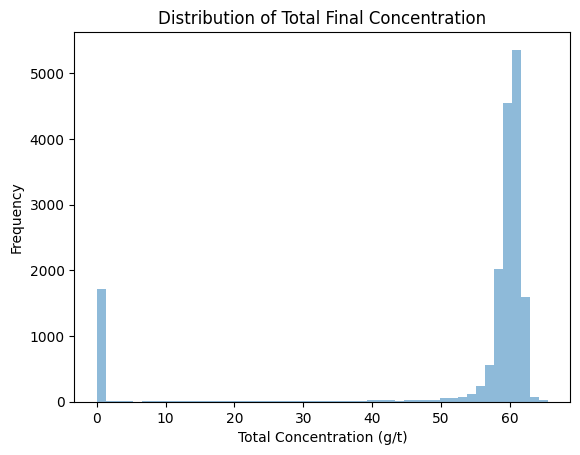

Number of zero total concentrations in Feed: 1209
Number of zero total concentrations in Rougher: 1544
Number of zero total concentrations in Final: 1320


In [13]:
# 
train_df['total_feed'] = train_df[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
train_df['total_rougher'] = train_df[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
train_df['total_final'] = train_df[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)


## Visualize Distributions:
train_df['total_feed'].plot.hist(bins=50, alpha=0.5)
plt.title('Distribution of Total Feed Concentration')
plt.xlabel('Total Concentration (g/t)')
plt.ylabel('Frequency')
plt.show()

train_df['total_rougher'].plot.hist(bins=50, alpha=0.5)
plt.title('Distribution of Total Rougher Concentration')
plt.xlabel('Total Concentration (g/t)')
plt.ylabel('Frequency')
plt.show()

train_df['total_final'].plot.hist(bins=50, alpha=0.5)
plt.title('Distribution of Total Final Concentration')
plt.xlabel('Total Concentration (g/t)')
plt.ylabel('Frequency')
plt.show()

# Number of zeros in each stage
num_zeros_feed = (train_df['total_feed'] == 0).sum()
num_zeros_rougher = (train_df['total_rougher'] == 0).sum()
num_zeros_final = (train_df['total_final'] == 0).sum()
print(f"Number of zero total concentrations in Feed: {num_zeros_feed}")
print(f"Number of zero total concentrations in Rougher: {num_zeros_rougher}")
print(f"Number of zero total concentrations in Final: {num_zeros_final}")

- Our visual representation of Total Feed Concentration perfectly displays what we expect to see throughout the Gold recovery process.
    - While all metals are represented in these graphs, the overall goal is the have a higher concentration in the the final stage.
    - Higher final concentrations mean we are capturing the metals rather than letting them slip through the cracks.
    - These visual representations confirm that our recovery process is indeed working as intended.
- Worth noting again is the frequency spike around 0
    - We already adressed this in the Feed Particle Distribution section.
    - These outliers wont effect our overall analysis and can be explained as: error, operational shutdown, no metal in sample.


In [14]:
# Remove the temporary total concentration columns
train_df = train_df.drop(columns=['total_feed', 'total_rougher', 'total_final'])

## Modeling our Data:

### sMAPE Function for Model Analysis:

In [15]:
## Custom sMAPE Function
def smape_function(actual_rougher, predicted_rougher, actual_final, predicted_final):
    """Calculate the combined sMAPE for rougher and final stages."""
    def smape(actual, predicted):
        return 100 * np.mean(np.abs(predicted - actual) / ((np.abs(actual) + np.abs(predicted)) / 2))
    
    smape_rougher = smape(actual_rougher, predicted_rougher)
    smape_final = smape(actual_final, predicted_final)
    
    combined_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return combined_smape

- We have created a sMAPE function for our model analysis:
    - This function is meant to measure how far off the models predictions are compared to the actual values and express it as a percentage.
    - Simply put, the lower the number our sMAPE fuction outputs, the better our model predicts our data.

### Linear Regression Model:

In [16]:
## Train multiple models and use cross validation, then evaluate with sMAPE, choose best model based on sMAPE score:

# Prepare list of columns to drop. missing_in_test is an Index -> convert to list
cols_to_drop = ['rougher.output.recovery', 'final.output.recovery', 'date'] + list(missing_in_test)
features = train_df.drop(columns=cols_to_drop)

target_rougher = train_df['rougher.output.recovery']
target_final = train_df['final.output.recovery']


# LinearRegression does not accept random_state
model = LinearRegression()

scores_lr_rougher = cross_val_score(model, features, target_rougher, cv=5)
predicted_rougher_lr = cross_val_predict(model, features, target_rougher, cv=5)
print("Cross-validation scores for Linear Regression on Rougher Recovery:", scores_lr_rougher)
avg_score_lr_rougher = scores_lr_rougher.mean()
print("Average cross-validation score for Linear Regression on Rougher Recovery:", avg_score_lr_rougher)


scores_lr_final = cross_val_score(model, features, target_final, cv=5)
predicted_final_lr = cross_val_predict(model, features, target_final, cv=5)
print("Cross-validation scores for Linear Regression on Final Recovery:", scores_lr_final)
avg_score_lr_final = scores_lr_final.mean()
print("Average cross-validation score for Linear Regression on Final Recovery:", avg_score_lr_final)

lr_smape = smape_function(target_rougher, predicted_rougher_lr, target_final, predicted_final_lr)
print("Combined sMAPE for Linear Regression:", lr_smape)



Cross-validation scores for Linear Regression on Rougher Recovery: [-0.29812642  0.16513905 -0.08325658 -0.1271949  -0.47565934]
Average cross-validation score for Linear Regression on Rougher Recovery: -0.16381963745673972
Cross-validation scores for Linear Regression on Final Recovery: [-0.1389166  -0.09596087 -0.09314813 -0.3146479  -0.21805496]
Average cross-validation score for Linear Regression on Final Recovery: -0.17214569315100006
Combined sMAPE for Linear Regression: 13.934299223253893


/Users/g_stod/Desktop/NQ_BOT/.conda/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/g_stod/Desktop/NQ_BOT/.conda/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/g_stod/Desktop/NQ_BOT/.conda/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/g_stod/Desktop/NQ_BOT/.conda/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/g_stod/Desktop/NQ_BOT/.conda/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/g_stod/Desktop/NQ_BOT/.conda/lib/python3.12/site-package

### Random Forest:

In [17]:
model = RandomForestRegressor(n_estimators= 50,max_depth=10,random_state=12345)



scores_rf_rougher = cross_val_score(model, features, target_rougher, cv=5)
predicted_rougher_rf = cross_val_predict(model, features, target_rougher, cv=5)
print("Cross-validation scores for Random Forest on Rougher Recovery:", scores_rf_rougher)
avg_score_rf_rougher = scores_rf_rougher.mean()
print("Average cross-validation score for Random Forest on Rougher Recovery:", avg_score_rf_rougher)

scores_rf_final = cross_val_score(model, features, target_final, cv=5)
predicted_final_rf = cross_val_predict(model, features, target_final, cv=5)
print("Cross-validation scores for Random Forest on Final Recovery:", scores_rf_final)
avg_score_rf_final = scores_rf_final.mean()
print("Average cross-validation score for Random Forest on Final Recovery:", avg_score_rf_final)


rf_smape = smape_function(target_rougher, predicted_rougher_rf, target_final, predicted_final_rf)
print("Combined sMAPE for Random Forest:", rf_smape)



Cross-validation scores for Random Forest on Rougher Recovery: [-0.06876868  0.08714906  0.0422542  -0.10761097 -0.45826243]
Average cross-validation score for Random Forest on Rougher Recovery: -0.10104776187756515
Cross-validation scores for Random Forest on Final Recovery: [ 0.03322588  0.11516682 -0.09551056 -0.1173558  -0.23590527]
Average cross-validation score for Random Forest on Final Recovery: -0.0600757857982301
Combined sMAPE for Random Forest: 13.082445471098463


- We have now applied two seperate Regression models to our data in order to discover which model is most accurate for further use.

- With the use of Cross Validation we are able to train and evaluate our model across folds of our data and see how it scores.

- Then using the custom fuction we created we are able to calculate the sMAPE for each model. 
    - As mentioned before, the lower the sMAPE value, the greater the models predicting power is.
    - The results show that our Random Forest Regressor edges out our Liner Regression model.
- Further analysis of the Test dataset should be conducted using Radom Forest Regressor.

## Modeling on Test Dataset:

In [18]:
# Merge based on date column
#full_df = full_df.fillna(method='ffill')
# 1. Pull the targets from full_df
targets = full_df[['date', 'rougher.output.recovery', 'final.output.recovery']]

# 2. Merge them onto the test set
test_with_targets = test_df.merge(targets, on='date', how='left')
test_targets_rougher = test_with_targets['rougher.output.recovery'].values
test_targets_final = test_with_targets['final.output.recovery'].values


In [19]:
# Final Model Training on Test Dataset:

final_rf_rougher = RandomForestRegressor(n_estimators= 50,max_depth=10,random_state=12345)
final_rf_final = RandomForestRegressor(n_estimators= 50,max_depth=10,random_state=12345)

final_rf_rougher.fit(features, target_rougher)
final_rf_final.fit(features, target_final)

test_predictions_rougher = final_rf_rougher.predict(test_df.drop(columns=['date']))
test_predictions_final = final_rf_final.predict(test_df.drop(columns=['date'])) 

final_smape = smape_function(test_targets_rougher, test_predictions_rougher, test_targets_final, test_predictions_final)
print("Final sMAPE on Test Dataset using Random Forest:", final_smape)





Final sMAPE on Test Dataset using Random Forest: 11.894501823413709


# Conclusion:

- Applying the Random Forest Regressor to our Test dataset yielded even better results than we achieved in our training set. 
- We were about to achieve a sMAPE of 11.89
    - This basically means that our models predictions around within 11.89% of actual recovery rates!
- Throughout the process of cleaning/visualizing/analyzing the data we have developed a model that is able to predict the recovery rates of Gold within 11.89%
- We are confident in our model for future use in prediction/forecasting Gold recovery.